# Overview

This worksheet will introduce you to the data formats we use in CMS for b-tagging, a crucial analysis technique that relies on pattern recognition to distinguish jets based on their originating hadron.

The goal would be to:
  * understand the basic contents of the data (jets and their properties)
  * compare the performances different discriminators
  * understand dependencies between jet kinematics and discriminator performance
  
The main public references are:
  * **[1]** Run 1 b-tagging at CMS: https://arxiv.org/pdf/1211.4462.pdf
  * **[2]** Run 2 b-tagging at CMS: http://inspirehep.net/record/1427161/files/BTV-15-001-pas.pdf

Prior to starting, you must set up the following packages:

* ROOT (v6): available from http://root.cern.ch
* root_numpy (latest from git): available from http://rootpy.github.io/root_numpy/install.html#getting-the-latest-source
* matplotlib, seaborn, pandas: available from `pip`

In [2]:
#set up paths
import sys
sys.path += [
    "/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/python/"
]

In [3]:
import root_numpy as rnpy
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import ROOT

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

import sklearn_cls

Welcome to ROOTaaS 6.06/01


We use input data from CMS Run II simulation at 13 TeV. We do this in order to have access to the latest-and-greatest b-taggers from CMS within the same framework that CMS uses to train the taggers, so that we could compare against state of the art. This also means that these data nor results derived using these data are **NOT** meant for public presentation or consumption, but are subject to prior approval from CMS.

Download the file from

http://hep.kbfi.ee/~joosep/qcd_1000_inf.root

Here we list various input files for our samples. We mainly rely on QCD multijet and ttbar+jets simulation.

In [7]:
infiles = {
    "ttjets": "file:///mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/data/tagvar/ttjets.root"
}

In [10]:
tf = ROOT.TFile.Open(infiles["ttjets"])
tt = tf.Get("tagVars/ttree")

What do we have in the data? It's about 4.7M simulated jets.

In [12]:
tt.GetEntries()

4753776L

We list all the variables we have available in the data.

In [13]:
for branch in sorted(tt.GetListOfBranches(), key=lambda x: x.GetName()):
    print branch.GetName()

Jet_CSV
Jet_CSVIVF
Jet_JBP
Jet_JP
Jet_SoftEl
Jet_SoftMu
Jet_cMVA
Jet_eta
Jet_flavour
Jet_genpt
Jet_jetIndex
Jet_mass
Jet_nbHadrons
Jet_phi
Jet_pt
TagVarCSV_flightDistance2dSig
TagVarCSV_flightDistance2dVal
TagVarCSV_flightDistance3dSig
TagVarCSV_flightDistance3dVal
TagVarCSV_jetNSecondaryVertices
TagVarCSV_jetNTracks
TagVarCSV_jetNTracksEtaRel
TagVarCSV_trackDecayLenVal_0
TagVarCSV_trackDecayLenVal_1
TagVarCSV_trackDecayLenVal_2
TagVarCSV_trackDecayLenVal_3
TagVarCSV_trackDeltaR_0
TagVarCSV_trackDeltaR_1
TagVarCSV_trackDeltaR_2
TagVarCSV_trackDeltaR_3
TagVarCSV_trackEtaRel_0
TagVarCSV_trackEtaRel_1
TagVarCSV_trackEtaRel_2
TagVarCSV_trackEtaRel_3
TagVarCSV_trackJetDist_0
TagVarCSV_trackJetDist_1
TagVarCSV_trackJetDist_2
TagVarCSV_trackJetDist_3
TagVarCSV_trackPtRatio_0
TagVarCSV_trackPtRatio_1
TagVarCSV_trackPtRatio_2
TagVarCSV_trackPtRatio_3
TagVarCSV_trackPtRel_0
TagVarCSV_trackPtRel_1
TagVarCSV_trackPtRel_2
TagVarCSV_trackPtRel_3
TagVarCSV_trackSip2dSigAboveCharm
TagVarCSV_trackSip2d

First we concentrate on the variables that start with `Jet_*`.

The jet kinematics are described by it's 4-momentum in spherical coordinates:
(`Jet_pt`, `Jet_eta`, `Jet_phi`, `Jet_mass`).

Since we are dealing with MC simulation, we can identify the hadron that produced this jet. This information is stored in `Jet_flavour`, which gives us the PDG ID code of the hadron.
The ID codes are

* 5: b-hadron (signal)
* 4: c-hadron (signal-like background)
* 1-3: uds-hadron (background)
* 21: gluon (background)

Finally, we have the CMS b-tagging information, in the form of the various b-taggers available within CMS. All of these are trained to distinguish between udsg, c jets (light, charm) and b-jets.

* `Jet_CSV`: the older combined secondary vertex (CSV) algorithm, based on the adaptive vertex finder algorithm, varies from $[0\dots1]$.
* `Jet_CSVIVF`: the newer CSV algorithm based on a different vertex finder, varies from $[0\dots1]$.
* `Jet_JP`: the simple Jet Probability (JP) based algorithm, varies from $[0\dots \inf]$
* `Jet_JBP`: an alternative way of calculating the JP, varies from $[0\dots \inf]$
* `Jet_SoftMu`: a b-tagger algorithm that uses the presence of a low-$p_T$ (soft) muon in a b-hadron to identify a b-jet
* `Jet_SoftEl`: as above, but based on an electron
* `Jet_cMVA`: an algorithm that combines the above information into a single discriminator

Now let's look at the data.

In [14]:
def load_data(fn, **kwargs):
    data = pd.DataFrame(rnpy.root2array(
        fn,
        treename="tagVars/ttree",
        **kwargs
    ))
    
    #Here we categorize the data according to the jet pdgId into 4 main groups
    data["Jet_flavour_abs"] = data["Jet_flavour"].abs().astype(np.int)
    data["flavour_category"] = ""
    data.loc[data["Jet_flavour_abs"] <= 3, "flavour_category"] = "light"
    data.loc[data["Jet_flavour_abs"] == 4, "flavour_category"] = "charm"
    data.loc[data["Jet_flavour_abs"] == 5, "flavour_category"] = "bhad"
    data.loc[data["Jet_flavour_abs"] == 21, "flavour_category"] = "gluon"
    
    data = data.drop("Jet_flavour", 1)
    return data

In [17]:
data = sklearn_cls.load_data(infiles["ttjets"], "tagVars/ttree", 0, tt.GetEntries(), [b.GetName() for b in tt.GetListOfBranches()], "")
data = sklearn_cls.preprocess(data)

In [19]:
#alternatively load data from CSV
#data.to_csv("/Users/joosep/Documents/btv/data/Oct4/qcd_1000_inf.csv.bz2", compression="bz2")
#data = pd.DataFrame.from_csv("/Users/joosep/Documents/btv/data/Oct4/qcd_1000_inf.csv.bz2")

data.shape

(4753776, 70)

Because many of the columns contain placeholder values that may be quite different and not numerically well-behaved, we need to replace them, for example the **Jet_CSV** discriminator changes from $[0, 1]$, but has a placeholder value of $-10$ in case a secondary vertex was not found. For using it as an input, we'd like to get rid of this large peak at $-10$ and properly normalize the variable to have a $\mu=0$ and $\sigma=1$.

In [20]:
cols_replacevals = {
    "Jet_CSV": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_CSVIVF": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_cMVA": {"replaceval_bad": -1, "replaceval_low": -1, "replaceval_high": 1},
    "Jet_JP": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 5},
    "Jet_JBP": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 15},
    "Jet_SoftMu": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
    "Jet_SoftEl": {"replaceval_bad": 0, "replaceval_low": 0, "replaceval_high": 1},
}

In [22]:
data = sklearn_cls.normalize_all_cols(data, cols_replacevals)

In [23]:
data_by_flavour = data.groupby("flavour_category")

In [24]:
data.groupby("flavour_category")[["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]].describe()

Jet_CSV    Jet_CSVIVF        Jet_JP  \
flavour_category                                                   
bhad             count  1.607441e+06  1.607441e+06  1.607441e+06   
                 mean   7.495745e-01  7.862915e-01  6.864944e-01   
                 std    3.009374e-01  2.812718e-01  4.658278e-01   
                 min    0.000000e+00  0.000000e+00 -0.000000e+00   
                 25%    5.595300e-01  6.811091e-01  3.349426e-01   
                 50%    8.983772e-01  9.224707e-01  6.211735e-01   
                 75%    9.845240e-01  9.879113e-01  9.744747e-01   
                 max    1.000000e+00  1.000000e+00  3.257209e+00   
charm            count  6.010980e+05  6.010980e+05  6.010980e+05   
                 mean   3.913994e-01  4.290218e-01  2.662838e-01   
                 std    2.865762e-01  2.957908e-01  2.447322e-01   
                 min    0.000000e+00  0.000000e+00 -0.000000e+00   
                 25%    1.514588e-01  1.635331e-01  6.714126e-02   
                 50%    2.859186e-01  3.424392e-01  2.035231e-01   
                 75%    6.426325e-01  7.176797e-01  4.045145e-01   
                 max    9.993541e-01  9.994373e-01  2.385683e+00   
gluon            count  1.144969e+06  1.144969e+06  1.144969e+06   
                 mean   2.214898e-01  2.437883e-01  1.141657e-01   
                 std    1.588808e-01  1.787335e-01  1.259466e-01   
                 min    0.000000e+00  0.000000e+00 -0.000000e+00   
                 25%    1.237647e-01  1.297062e-01  2.088007e-02   
                 50%    1.723378e-01  1.837543e-01  7.427374e-02   
                 75%    2.681506e-01  3.058340e-01  1.652420e-01   
                 max    9.994322e-01  9.993951e-01  2.637349e+00   
light            count  1.400268e+06  1.400268e+06  1.400268e+06   
                 mean   2.056742e-01  2.212916e-01  1.062519e-01   
                 std    1.604749e-01  1.756821e-01  1.249888e-01   
                 min    0.000000e+00  0.000000e+00 -0.000000e+00   
                 25%    1.058145e-01  1.088573e-01  1.311205e-02   
                 50%    1.567755e-01  1.628720e-01  6.478011e-02   
                 75%    2.507708e-01  2.769328e-01  1.541319e-01   
                 max    9.994632e-01  9.994693e-01  2.118562e+00   

                             Jet_JBP    Jet_SoftMu    Jet_SoftEl  
flavour_category                                                  
bhad             count  1.607441e+06  1.607441e+06  1.607441e+06  
                 mean   3.229390e+00  9.917881e-02  1.169064e-01  
                 std    1.983138e+00  2.273075e-01  2.773655e-01  
                 min   -0.000000e+00  0.000000e+00  0.000000e+00  
                 25%    1.663355e+00  0.000000e+00  0.000000e+00  
                 50%    3.014712e+00  0.000000e+00  0.000000e+00  
                 75%    4.620854e+00  0.000000e+00  0.000000e+00  
                 max    1.091985e+01  8.300437e-01  9.982125e-01  
charm            count  6.010980e+05  6.010980e+05  6.010980e+05  
                 mean   1.290675e+00  4.183304e-02  5.718919e-02  
                 std    1.100206e+00  1.443063e-01  1.865931e-01  
                 min   -0.000000e+00  0.000000e+00  0.000000e+00  
                 25%    4.262206e-01  0.000000e+00  0.000000e+00  
                 50%    1.007546e+00  0.000000e+00  0.000000e+00  
                 75%    1.878785e+00  0.000000e+00  0.000000e+00  
                 max    9.621180e+00  8.074902e-01  9.947855e-01  
gluon            count  1.144969e+06  1.144969e+06  1.144969e+06  
                 mean   6.175871e-01  1.636732e-02  2.940180e-02  
                 std    5.870458e-01  9.152567e-02  1.214854e-01  
                 min   -0.000000e+00  0.000000e+00  0.000000e+00  
                 25%    1.998226e-01  0.000000e+00  0.000000e+00  
                 50%    4.456828e-01  0.000000e+00  0.000000e+00  
                 75%    8.525165e-01  0.000000e+00  0.000000e+00  
                 max    1.091985e+01  7.8

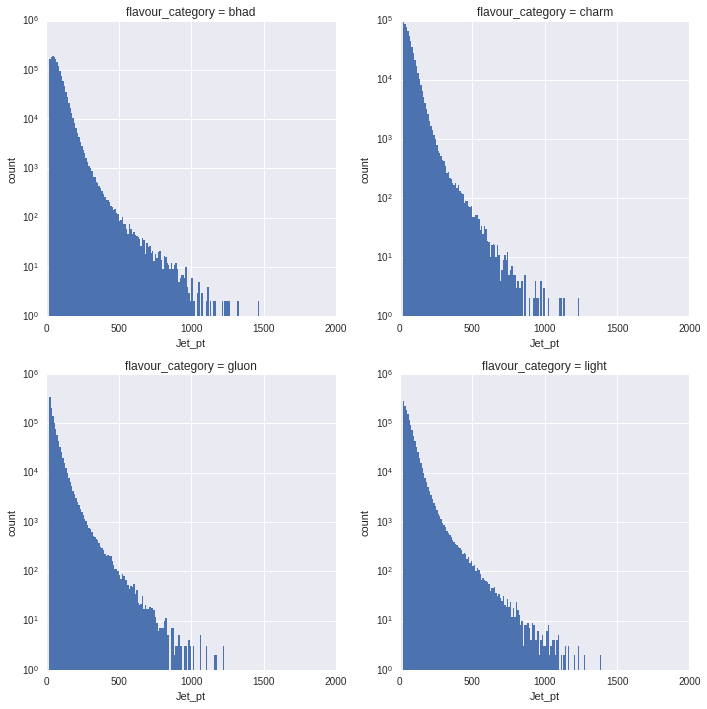

In [25]:
fig = seaborn.plt.figure(figsize=(10, 10))
for igroup, (name, group) in enumerate(data_by_flavour):
    seaborn.plt.subplot(len(data_by_flavour)/2, 2, igroup+1)
    seaborn.plt.title("flavour_category = {0}".format(name))
    seaborn.plt.xlabel("Jet_pt")
    seaborn.plt.ylabel("count")
    group["Jet_pt"].hist(bins=np.arange(0, 2000, 10), lw=0)
    seaborn.plt.yscale("log")
seaborn.plt.tight_layout()

Now let's look at one of the CMS flagship taggers in more detail. The Jet_CSVIVF column contains the output of the CMS Combined Secondary Vertex with Inclusive Vertex Filtering tagger, which varies from $[0\dots1]$ and is designed to separate light jets from b-jets. It is a multivariate tagger, based on a set of boosted decision trees trained on a combination of input variables.
The majority of CMS analyses in Run II rely on this tagger.

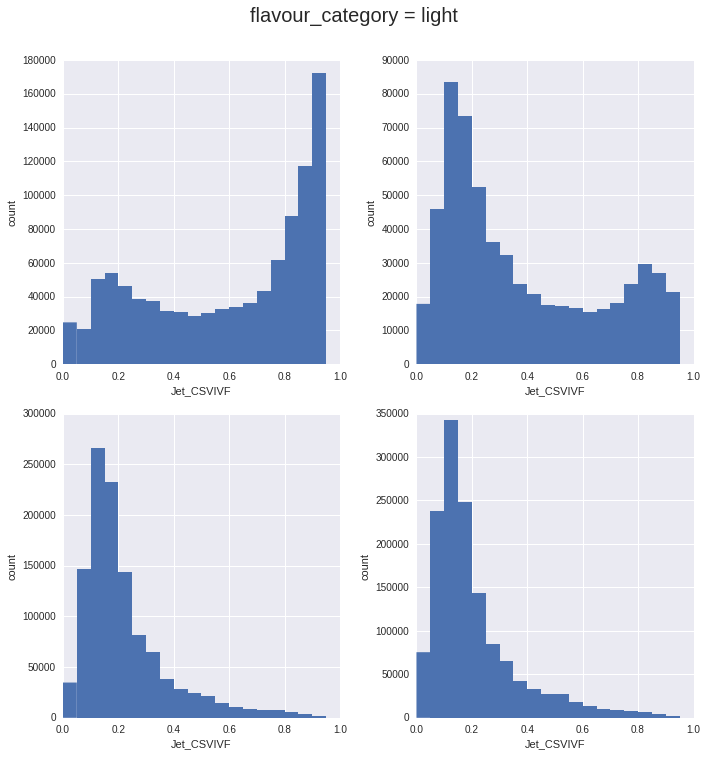

In [28]:
fig = seaborn.plt.figure(figsize=(10, 10))
for igroup, (name, group) in enumerate(data_by_flavour):
    seaborn.plt.subplot(len(data_by_flavour)/2, 2, igroup+1)
    seaborn.plt.suptitle("flavour_category = {0}".format(name), fontsize=20, y=1.05)
    seaborn.plt.xlabel("Jet_CSVIVF")
    seaborn.plt.ylabel("count")
    group["Jet_CSV"].hist(bins=np.arange(0,1,0.05), lw=0)
seaborn.plt.tight_layout()

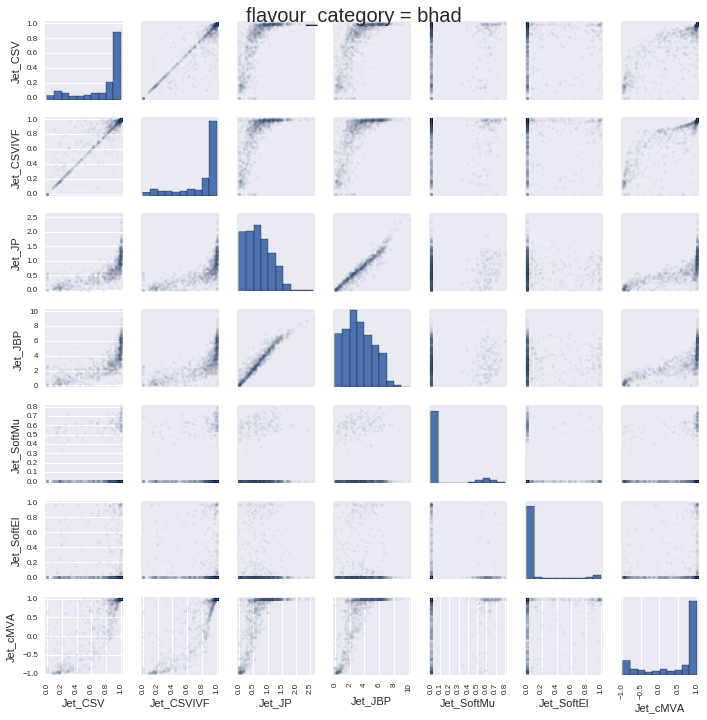

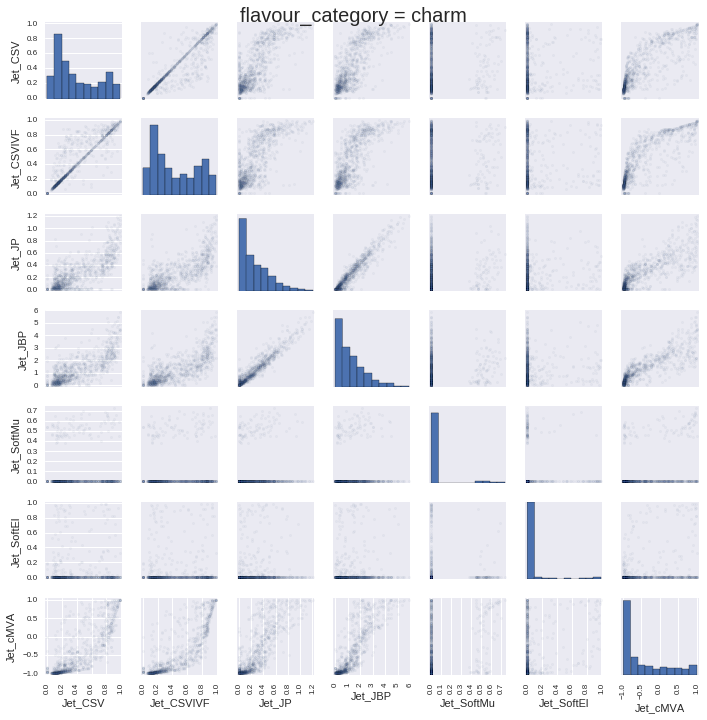

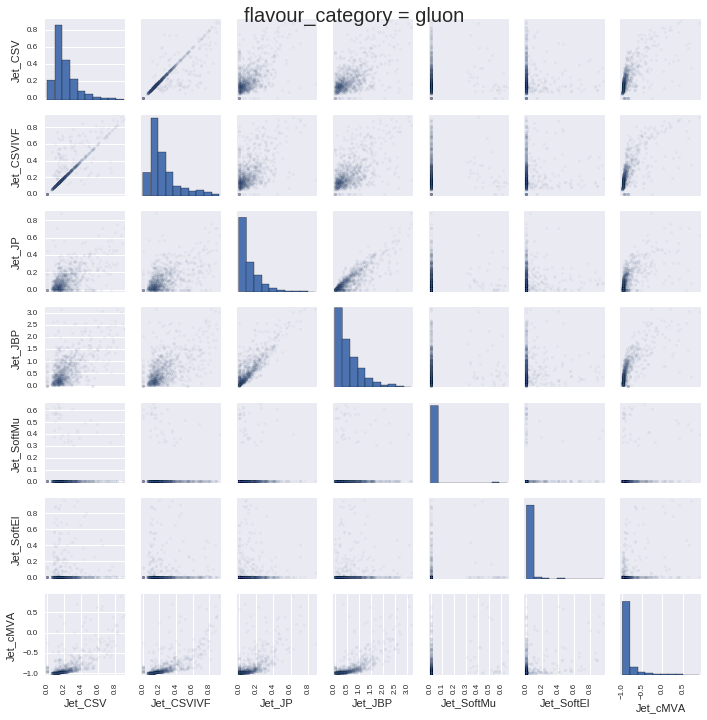

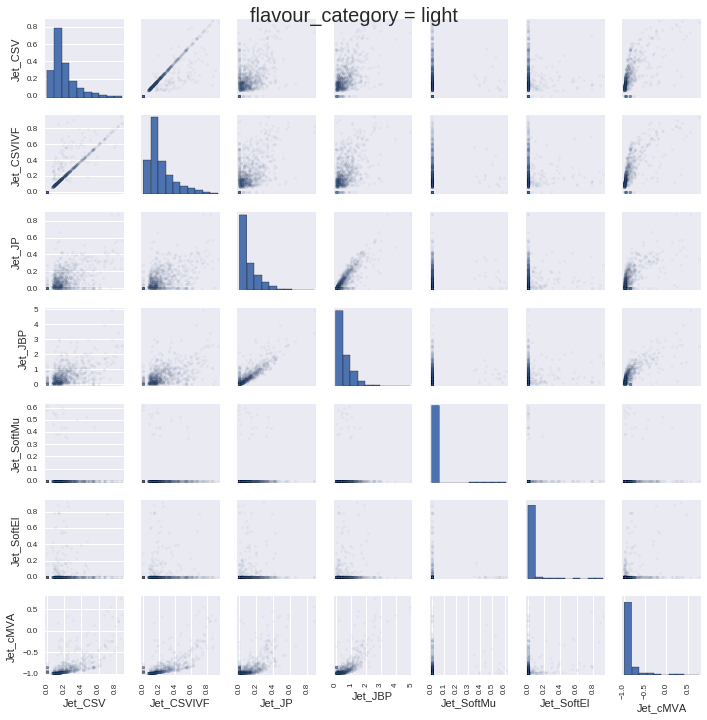

In [29]:
cols_for_scatter = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl", "Jet_cMVA"]
for igroup, (name, group) in enumerate(data_by_flavour):
    scatter_matrix(group[:1000][cols_for_scatter], alpha=0.05, figsize=(10, 10), diagonal='hist')
    seaborn.plt.suptitle("flavour_category = {0}".format(name), fontsize=20, y=1.00)
    seaborn.plt.tight_layout()

## Evaluating the performance of a discriminator

We'd like to objectively compare how well a discriminator does in distinguishing signal from background. The usual way of doing this is using so-called Receiver Operating Characteristic (ROC) curves.

 * Try to reproduce Figure 8 from Ref. [2]! Do you have all the necessary data for it? 
 * Study the performance of the taggers as a function of jet kinematics ($p_T$, $|\eta|$). Do you notice any trends?